In [1]:
import os
import itertools
import pickle
import math

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score
from scipy.stats import pearsonr
import krippendorff
pd.options.display.precision = 4

from lared_laughter.constants import annot_exp_path

In [2]:
matplotlib.rcParams.update({'font.size': 8})

# Reading the data..

In [6]:
results = pd.read_csv(os.path.join(annot_exp_path, 'processed', 'annotations_new.csv'), index_col=0)
cont_annot = pickle.load(open(os.path.join(annot_exp_path, 'processed', 'continuous.pkl'), 'rb'))
# assert len(results) == len(cont_annot), f'{len(results)} != {len(cont_annot)}'
# results.drop(['hit_id', 'hash'], axis=1).tail(10)

In [7]:
results.sort_values(by='hash').head()

,person,cam,hit_id,condition,calibration,hash,ini_time,end_time,_ini_time,_end_time,...,gt_offset,gt_laughter,is_laughter,confidence,intensity,rating_hash,attempt,pressed_key,onset,offset
494,9,2,3b804f3cf294726af761efaff5fb5974e2712846ce485d...,av,False,002043005fa746f076c845dc38dd1bd97327bde09e17fc...,7963.610,7965.490,7960.6024,7968.5339,...,4.9239,True,True,6,4,bc4c6e6a8ceb18d918d35cabb3b0273c65e8729c43e4a0...,0,True,3.4600,3.8938
1405,9,2,99cd9c6d87f8785f6ee01ff22ea0245811dff0968a9b12...,audio,False,002043005fa746f076c845dc38dd1bd97327bde09e17fc...,7963.610,7965.490,7960.6024,7968.5339,...,4.9239,True,True,7,4,18a15d2afcdcc7fb98aa5f8478e3399ec5a5a65ebf306c...,0,True,3.3032,3.8632
2371,9,2,eaa13e4245933c97dc9849959a66fc45ab72c0d165d1d4...,audio,False,002043005fa746f076c845dc38dd1bd97327bde09e17fc...,7963.610,7965.490,7960.6024,7968.5339,...,4.9239,True,True,7,3,fe660ff7f60616a6950b10833e9360bfdc12a6d70837b0...,0,True,3.3032,4.1432
64,9,2,024a80de5a3a053d40e1b7f3086e70c34cd90fc2a9668c...,av,False,002043005fa746f076c845dc38dd1bd97327bde09e17fc...,7963.610,7965.490,7960.6024,7968.5339,...,4.9239,True,True,7,6,a9d236ff9a3dc04f8d8f62eff6ebdbbdd7cf32a564c18a...,1,True,3.3599,4.3609
2482,30,4,ec302308ddc965b13a5c7b458ad819f8b845f73d914215...,av,False,006f74addfc99845bf6c9f80d13d52ccc1893410315255...,8289.657,8292.107,8287.7300,8295.1772,...,5.5202,True,True,7,3,d75bf1619427846f65a85d95739f0867e93c7e9bd05f5b...,0,True,2.2588,4.2274


In [8]:
len(results), len(cont_annot)

(2863, 2863)

# Filter out invalid HITs
Some HITs never had a pressed key.

In [9]:
for hit_id in results['hit_id'].unique():
    for cond in results['condition'].unique():
        res = results.loc[(results['hit_id'] == hit_id) & (results['condition'] == cond) & (results['calibration'] == False) & results['pressed_key'].notnull()]
        
        if len(res['pressed_key'].unique()) == 1:
            print(f'{hit_id} : {cond} => pk: {res["pressed_key"].sum()} / {len(res)} | il:  {res["is_laughter"].sum()} / {len(res)}')

47d05370e41ca3944898561425eb80a67ee2dbc340a69b1bf7fffc5a8a1d461c : av => pk: 12 / 12 | il:  12 / 12
8a3a9686df3d4ce11340399cd22a0e7de4c37f858792f4765bddcf85d43a9d54 : audio => pk: 0 / 28 | il:  18 / 28
8a3a9686df3d4ce11340399cd22a0e7de4c37f858792f4765bddcf85d43a9d54 : av => pk: 0 / 28 | il:  21 / 28
8a3a9686df3d4ce11340399cd22a0e7de4c37f858792f4765bddcf85d43a9d54 : video => pk: 0 / 28 | il:  11 / 28


In [10]:
results_pk = results[(results['hit_id'] != '8a3a9686df3d4ce11340399cd22a0e7de4c37f858792f4765bddcf85d43a9d54')]
(len(results), len(results_pk))

(2863, 2773)

# Repetition of the recognition step

Here I look at how often different annotators repeated the recognition step
- Every column is a different person.
- *repeated* is the number of times they repeated a segment once
- *total* is the number of segments they completed

In [11]:
df = []
for hit_id in results['hit_id'].unique():
    subject_data = results[results['hit_id'] == hit_id]
    df.append({'repeated': subject_data['attempt'].sum(), 'total': len(subject_data)})
pd.DataFrame(df, dtype=int).transpose()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
repeated,3,0,1,4,1,13,0,4,5,0,...,0,4,0,0,1,7,16,0,2,4
total,90,90,90,90,90,90,90,73,90,90,...,90,90,90,90,90,90,90,90,90,90


# Obvious / clear examples

In [12]:
results['duh_score'] = (results['intensity'] - results['intensity'].mean()) / results['intensity'].std() * 1/2 \
                         + (results['confidence'] - results['confidence'].mean()) / results['confidence'].std() * 1/2

In [13]:
duh_scores = []
for hash in results['hash'].unique():
    example_results = results[results['hash'] == hash]
    duh_score = example_results['duh_score'].mean()
    if len(example_results) >= 4:
        duh_score  = duh_score * 2/3 + (1-example_results['onset'].std()) * 1/3
    duh_scores.append({'hash': hash, 'score': duh_score, 'calib': example_results.iloc[0]['calibration']})

In [14]:
pd.options.display.max_colwidth

50

In [15]:
pd.options.display.max_colwidth = 100
pd.DataFrame(duh_scores).sort_values(by='score', ascending=False).head(5)

,hash,score,calib
132,8fe32db8e94826b81b1b3bcd08d829ec73a7aa7f4c6e90eba4e949d891aece52,1.0657,False
119,54265351abec7e979caf5e967c8db5f4e36d8a80e99fd9a66685842e021f767f,1.0117,False
67,6f4bc952a214878c1268169ef4c18245d58fb805abaaa77c144c0f31be42c3f0,0.9969,False
263,9c35a317632066a07bc668ca298da67a1ae92f3117cef0f14a9480dc99ee8c68,0.9162,False
75,ced6e78fe7940c10fbc9d7c385273e68459ca399ccb668c8123cf5a66fa99819,0.8939,True


# Duration of the experiment

Here I just read the timestamps to figure out the time that it took people to complete the experiment.

# Comparing to GT

Here I compare the results to my "GT" annotations in precision and recall. Especially interested in video-only and audio-only cases

- Every row is a HIT or annotator

In [16]:
df = {}
for hit_id in results['hit_id'].unique():
    row = {}
    for condition in results['condition'].unique():
        
        X = results.loc[(results['hit_id'] == hit_id) & (results['condition'] == condition) & (results['calibration'] == False) & results['pressed_key'].notnull()]
        # comparing laughter recognition
        precision, recall, _, _ = precision_recall_fscore_support(X['gt_laughter'].to_list(), X['pressed_key'].to_list(), labels=[0,1], zero_division=0)
        row[f'{condition}_precision'] = precision[1]
        row[f'{condition}_recall'] = recall[1]
    df[hit_id] = row
pd.DataFrame(df.values()).transpose().mean(axis=1)

audio_precision    0.9248
audio_recall       0.8964
av_precision       0.9232
av_recall          0.9203
video_precision    0.8685
video_recall       0.6739
dtype: float64

# Interannotator agreement

Pairwise interrater agreement for the categorical variables
- Laughter presence
- Laughter intensity
- Confidence

In [17]:
def calc_agreement(results, var, agreement_fn):
    
    values = {}
    std = {}
    counts = {}
    raw = {}
    for condition in results['condition'].unique():
        condition_values = []
        hit_pairs = itertools.combinations(results['hit_id'].unique(), 2)

        for hit_a, hit_b in hit_pairs:
            a = results.loc[(results['hit_id'] == hit_a) & (results['condition'] == condition) & (results['calibration'] == False) & results[var].notnull()]
            b = results.loc[(results['hit_id'] == hit_b) & (results['condition'] == condition) & (results['calibration'] == False) & results[var].notnull()]

            # get the intersection of both annotator's examples
            intersection = pd.merge(a, b, how='inner', on=['hash'])
            if len(intersection) < 20:
                continue
            # print('calc')
            try:
                value = agreement_fn(intersection[f'{var}_x'].to_list(), intersection[f'{var}_y'].to_list())
            except RuntimeWarning:
                continue
            if math.isnan(value):
                print('nan')
                continue

            if value == 0:
                print(f'zero agreement for A = {hit_a}, B={hit_b}, cond={condition}')
            condition_values.append(value)

        values[condition] = np.mean(condition_values)
        std[condition] = np.std(condition_values)
        counts[condition] = len(condition_values)
        raw[condition] = condition_values

    return values, std, counts, raw

## Kappa for binary variables

Here I calculate cohen's kappa for the three conditions for:
- pressed_key: the binarization of the continuous annotation
- is_laughter: the switch on the Rating page

In [18]:
def kappa_fn(a, b):
    return cohen_kappa_score(a, b)

In [19]:
values, std, counts, raw = calc_agreement(results_pk, 'pressed_key', kappa_fn)


In [20]:
pd.DataFrame([values])

,audio,av,video
0,0.8441,0.8148,0.5723


In [21]:
values, std, counts, raw = calc_agreement(results, 'is_laughter', kappa_fn)

zero agreement for A = bad9b2bbdc09dcd0f3dd68a24026050b13a2047e963574a54fd9f55d49b278ac, B=ca71c4394f8274421f05669317a99ce9d76a11a8fda92c6cc35260cf8f707ee1, cond=audio
zero agreement for A = bad9b2bbdc09dcd0f3dd68a24026050b13a2047e963574a54fd9f55d49b278ac, B=ca71c4394f8274421f05669317a99ce9d76a11a8fda92c6cc35260cf8f707ee1, cond=av
zero agreement for A = bad9b2bbdc09dcd0f3dd68a24026050b13a2047e963574a54fd9f55d49b278ac, B=ca71c4394f8274421f05669317a99ce9d76a11a8fda92c6cc35260cf8f707ee1, cond=video


In [22]:
pd.DataFrame([values])

,audio,av,video
0,0.7561,0.7809,0.5493


## Agreement in intensity and confidence

For now I'm  calculating correelation for this. Could be that some Kappa measures or Krippendorfs alpha would be better measures

In [23]:
def pearson_corr(a, b):
    return pearsonr(a, b)[0]

In [24]:
def kpd_alpha(a,b):
    return krippendorff.alpha(np.vstack([a,b]))

In [26]:
values, std, counts, raw = calc_agreement(results, 'intensity', pearson_corr)
pd.DataFrame([values])

,audio,av,video
0,0.6184,0.6038,0.2001


In [27]:
values, std, counts, raw = calc_agreement(results, 'intensity', kpd_alpha)
pd.DataFrame([values])

,audio,av,video
0,0.5322,0.524,0.0885


In [143]:
values, std, counts, raw = calc_agreement(results_il, 'confidence', pearson_corr)
pd.DataFrame([values])

,video,audio,av
0,0.21,0.219,0.1411


In [28]:
values, std, counts, raw = calc_agreement(results, 'confidence', kpd_alpha)
pd.DataFrame([values])

,audio,av,video
0,0.0482,-0.0398,0.1269


# Correlating intensity and confidence

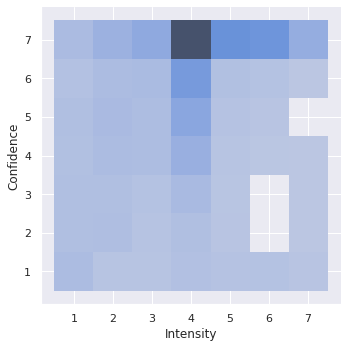

In [29]:
sns.set(rc={'figure.figsize':(2,2)})
fig = sns.displot(results, x='intensity', y='confidence', binwidth=1, binrange=[0.5,7.5]) 
fig.set_axis_labels('Intensity', 'Confidence')

In [37]:
from scipy.stats import spearmanr

In [38]:
spearmanr(results['intensity'], results['confidence'])

SpearmanrResult(correlation=0.3558629711818479, pvalue=1.5621109160828781e-91)

In [39]:
fig.savefig('./figures/confidence_intensity.png', dpi=300, bbox_inches='tight')

# Onset agreement

Here I plot a histogram of the differences in onset between annotations of the same segment (per condition)

- I only measure the differences when both annotators pressed the key
- Interesting plot but I think I need more samples for it to be useful

In [30]:
results['condition'].unique()

array(['audio', 'av', 'video'], dtype=object)

In [31]:
onset_diffs = {}
for condition in results['condition'].unique():
    onset_diffs[condition] = []

    hit_pairs = itertools.combinations(results['hit_id'].unique(), 2)
    for hit_a, hit_b in hit_pairs:
        a = results.loc[(results['hit_id'] == hit_a) & (results['condition'] == condition) & (results['calibration'] == False)]
        b = results.loc[(results['hit_id'] == hit_b) & (results['condition'] == condition) & (results['calibration'] == False)]

        # get the intersection of both annotator's examples
        intersection = pd.merge(a, b, how='inner', on=['hash'])
        if len(intersection) < 20:
            continue

        rows = intersection.loc[intersection['onset_x'].notna() & intersection['onset_y'].notna()]
        hit_diffs = np.abs(rows['onset_x'].to_numpy() - rows['onset_y'].to_numpy())
        onset_diffs[condition].append(hit_diffs)

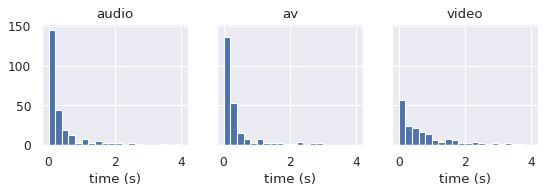

In [32]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(8, 2), dpi=80)
for i, (condition, diffs) in enumerate(onset_diffs.items()):
    condition_diffs = np.concatenate(diffs)
    ax[i].set_title(condition)
    ax[i].set_xlabel('time (s)')
    ax[i].hist(condition_diffs, bins=np.arange(0, 4 + 0.2, 0.2))

# Resolution

Here I calculate the fraction of skipped frames due to browser delay (user-specific)

In [43]:
one_fractions = []
num_all_zeroes = 0
for i, ca in enumerate(cont_annot):
    media_time = ca['media_time'].to_numpy()
    try:
        first_nonzero_idx = np.where(media_time != 0)[0][0]
    except:
        num_all_zeroes += 1
        continue
        # print(f'media time all zeroes for idx {i}')

    valid_data = media_time[first_nonzero_idx:]

    zero_idxs = np.where(valid_data == 0)[0]
    if len(zero_idxs) <= 1:
        first_zero_idx = len(zero_idxs) - 1
    else:
        first_zero_idx = zero_idxs[1]
    valid_data = valid_data[:first_zero_idx-1]
    one_fractions.append(np.sum(valid_data != 0) / len(valid_data))

In [44]:
(num_all_zeroes, len(cont_annot))

(180, 3043)

In [45]:
np.sum(np.array(one_fractions) == 1) / len(one_fractions)

0.9154732797764583

In [46]:
np.mean(one_fractions)

0.9991050848613752

# Annotation diagrams

Here I created diagrams of annotation onset and offset

In [33]:
results.head()

,person,cam,hit_id,condition,calibration,hash,ini_time,end_time,_ini_time,_end_time,...,gt_laughter,is_laughter,confidence,intensity,rating_hash,attempt,pressed_key,onset,offset,duh_score
0,21,1,024a80de5a3a053d40e1b7f3086e70c34cd90fc2a9668ccc6c47f7293425a185,audio,False,fec1e2585d21cffcf094c615b68e22dcc88dba1d31287773b2f11bf14e09043c,4117.1980,4117.6820,4115.6439,4119.5185,...,True,False,7,4,80686f50a88183c844460e76d34085728602fdcf45e98a3dfbfc59257dd5e619,0,False,NaN,NaN,0.4411
1,17,1,024a80de5a3a053d40e1b7f3086e70c34cd90fc2a9668ccc6c47f7293425a185,audio,False,ec84022e240482976063d686d8e9b1d59e0cbf9b46e763f658e8f2d130d15bbe,3480.7383,3488.2258,3480.7383,3488.2258,...,False,False,7,4,b646fb8e3448094fdee87a11bdc2d667f2e55dd801b2db473a4e182b350f4dd0,0,False,NaN,NaN,0.4411
2,7,1,024a80de5a3a053d40e1b7f3086e70c34cd90fc2a9668ccc6c47f7293425a185,audio,False,0987eb7c8da769fc6a38242d2cc4ab1daad329bb952aa8a88e7774d38d8c6c9f,5824.9800,5825.8800,5822.7343,5829.0501,...,True,True,7,6,6b6745682546434a956c6ef947b015d0b35500ca71326b48d99a7f141d4d0076,0,True,2.9432,4.1432,1.0930
3,23,1,024a80de5a3a053d40e1b7f3086e70c34cd90fc2a9668ccc6c47f7293425a185,audio,False,bbcf04f61b50904b044dee510cfec23030cb52006c0785094ef891be02ac13ee,7329.0950,7329.6790,7326.2076,7331.6872,...,True,True,7,3,cee709b18eea784f4eb6f0408b86fa5224f032c6d99806b9a1a4cf08b138d249,0,True,3.5032,3.9832,0.1151
4,7,2,024a80de5a3a053d40e1b7f3086e70c34cd90fc2a9668ccc6c47f7293425a185,audio,False,08755169b187562233dc5fabd6268a969fa61915c0d14cc70c37a9b4aa3e38e7,4187.7300,4193.8637,4187.7300,4193.8637,...,False,False,7,4,04cf4d5ce06b3f1488685bcd2e85c04a763923bf971ab01c8f25c6024a803f41,0,False,NaN,NaN,0.4411


In [49]:
def make_annot_diagram(ax, condition, reference='gt_ini', intensity=[1,7], confidence=[1,7]):
    # ignore samples without gt laughter
    df = results.loc[
        (results['intensity'] >= intensity[0]) & 
        (results['intensity'] <= intensity[1]) & 
        (results['confidence'] >= confidence[0]) & 
        (results['confidence'] <= confidence[1]) & 
        (results['condition'] == condition) & 
        (results[reference].notna()) & 
        results['pressed_key']]

    cont_annots = np.full((len(df), 30*6+1), np.nan) # 6 seconds @ 30fps
    for i, (index, response) in enumerate(df.iterrows()):
        ca = cont_annot[index]
        for index, row in ca.iterrows():
            if row['media_time'] == 0: # ignore skipped values
                continue
            sample_index = round(90 + (row['media_time'] - response[reference]) * 30)
            try:
                cont_annots[i, sample_index] = row['data0']
            except IndexError:
                pass

    mean_annots = np.nanmean(cont_annots, axis=0)
    times = np.arange(-3, 3+1/30, 1/30)
        
    ax.plot(times, mean_annots, linewidth=0.5)
    ax.axvline(x=0, linestyle='--', color='r', linewidth=0.5)
    ax.set_xticks(ticks=np.arange(-3,3,1))
    ax.set_xticks(ticks=np.arange(-3,3,0.2), minor=True)

In [50]:
def make_onset_offset_fig(intensity=[1,7], confidence=[1,7]):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(8, 4), sharey=True, sharex=True, dpi=150)
    make_annot_diagram(ax1, 'video', 'gt_ini', intensity, confidence)
    make_annot_diagram(ax2, 'audio', 'gt_ini', intensity, confidence)
    make_annot_diagram(ax3, 'av', 'gt_ini', intensity, confidence)
    make_annot_diagram(ax4, 'video', 'gt_end', intensity, confidence)
    make_annot_diagram(ax5, 'audio', 'gt_end', intensity, confidence)
    make_annot_diagram(ax6, 'av', 'gt_end', intensity, confidence)
    ax1.set_title('Video')
    ax2.set_title('Audio')
    ax3.set_title('Audiovisual')
    ax5.set_xlabel('time (s)')
    ax1.set_ylabel('mean(annotations)')
    ax4.set_ylabel('mean(annotations)')
    fig.savefig('./figures/onsets_offsets.png', dpi=300, bbox_inches='tight')

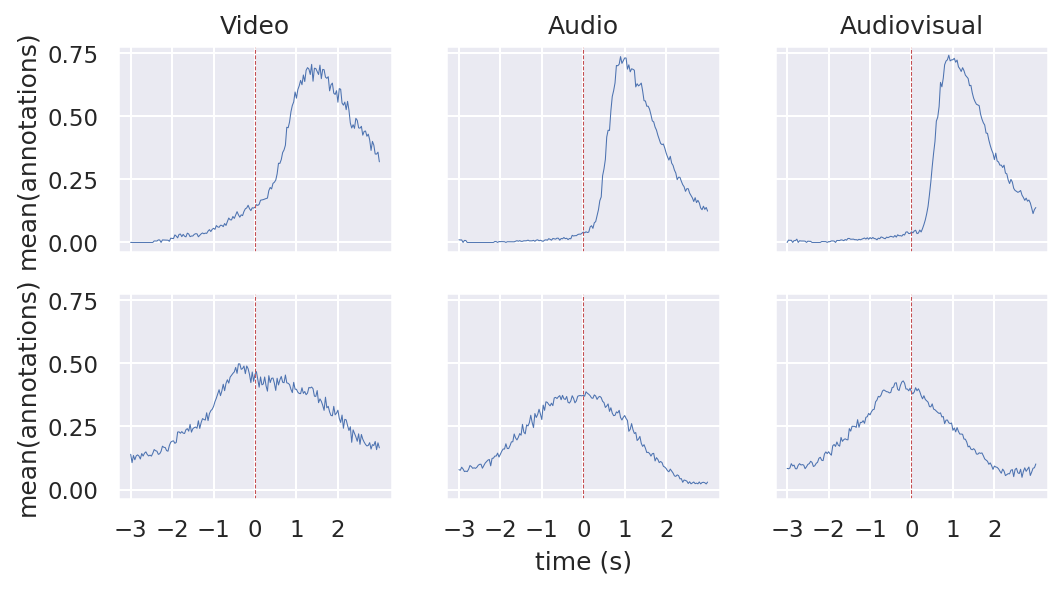

In [51]:
make_onset_offset_fig()

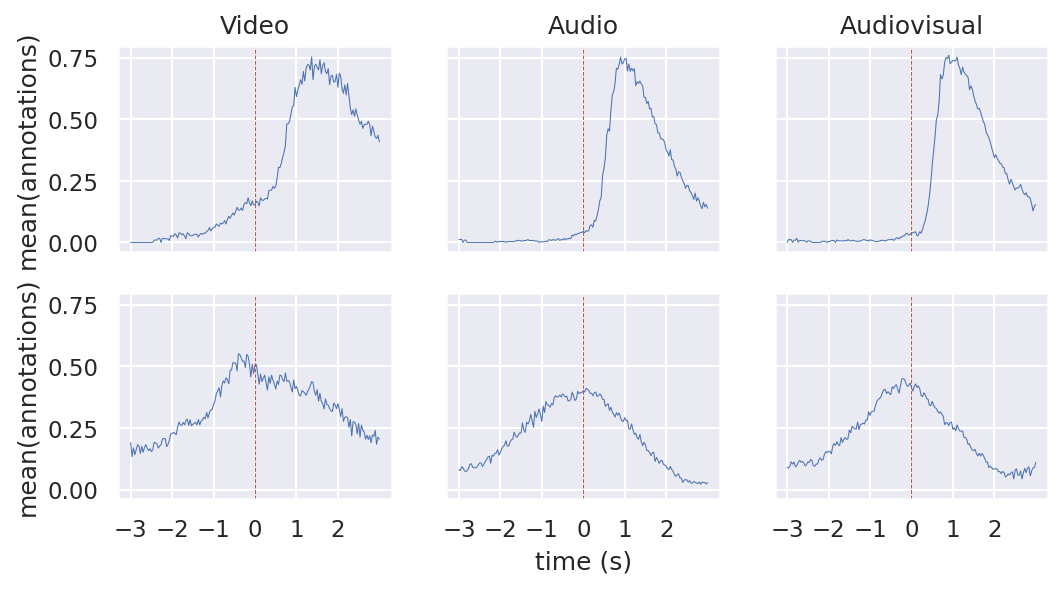

In [52]:
make_onset_offset_fig(confidence=[5,7])

# Reaction times

In [53]:
def make_reaction_time_diagram(ax, results, intervals):
    # ignore samples without gt laughter
    video_len = len(results[0])

    video_len = np.max([len(r['data']) for r in results])

    data = []
    for res in results:
        if len(res['data']) != video_len:
            print(f'unusual length for hit_id {res["hit_id"]}')
            continue
        data.append(res['data']['data0'].to_numpy())


    data = np.vstack(data)
        
    ax.plot(np.arange(data.shape[1])*1/30, np.nanmean(data, axis=0), linewidth=0.5, color='black')
    for intval in intervals:
        ini = round(intval[0])
        end = round(intval[1])
        # ax.axvline(x=ini, linestyle='--', color='r', linewidth=0.5)
        # ax.axvline(x=end, linestyle='--', color='r', linewidth=0.5)
        ax.axvspan(ini, end, facecolor='0.2', alpha=0.2)
    # ax.set_xticks(ticks=np.arange(-3,3,1))
    # ax.set_xticks(ticks=np.arange(-3,3,0.2), minor=True)

In [54]:
def make_reaction_time_fig(reaction_time_results):

    example0_results = [ex for ex in reaction_time_results if ex['example_id'] == 0]
    example2_results = [ex for ex in reaction_time_results if ex['example_id'] == 2]
    example4_results = [ex for ex in reaction_time_results if ex['example_id'] == 4]

    fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(4, 5), sharey=True, sharex=True, dpi=150)
    make_reaction_time_diagram(ax1, example0_results, example0_results[0]['gt_intervals'])
    make_reaction_time_diagram(ax2, example2_results, example2_results[0]['gt_intervals'])
    make_reaction_time_diagram(ax3, example4_results, example4_results[0]['gt_intervals'])
    # sns.set_style("whitegrid")
    ax3.set_xlabel('time (s)')
    ax1.set_ylabel('mean(annotations)')
    ax2.set_ylabel('mean(annotations)')
    ax3.set_ylabel('mean(annotations)')
    ax1.yaxis.grid(True)
    ax1.xaxis.grid(False)
    ax2.yaxis.grid(True)
    ax2.xaxis.grid(False)
    ax3.yaxis.grid(True)
    ax3.xaxis.grid(False)
    ax1.set_xticks(range(0,12), minor=True)
    fig.savefig('./figures/reaction_times.png', dpi=300, bbox_inches='tight')

In [55]:
reaction_time_results = pickle.load(open(os.path.join(pilot_path, 'reaction_time_results.pkl'), 'rb'))

unusual length for hit_id 694a4fa5b2a7733614c89f9c82605b95a39706c5f91a510d635dec64e994e19c
unusual length for hit_id ca937e8850406d600f550a0c751af3dce5cc45059621f4c530e1f8d6dbd17355
unusual length for hit_id 694a4fa5b2a7733614c89f9c82605b95a39706c5f91a510d635dec64e994e19c
unusual length for hit_id ca937e8850406d600f550a0c751af3dce5cc45059621f4c530e1f8d6dbd17355


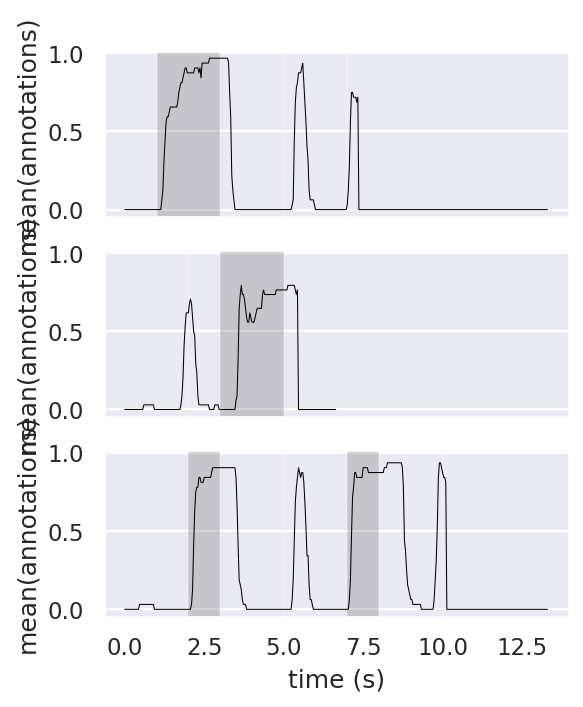

In [56]:
make_reaction_time_fig(reaction_time_results)

# Correction of delays

Here I correct the delays using the Calibration samples

In [57]:
calibration_examples = results[results['calibration']]

In [58]:
calibration_examples

,person,hit_id,condition,calibration,hash,gt_ini,gt_end,gt_laughter,is_laughter,confidence,intensity,attempt,pressed_key,onset,offset,duh_score
5,NaN,9c45e4f0c5442e796eb93e73e94dc6c2dfca7b9c4c54ff9314ab0956fc1f454a,av,True,bb6337eea970487ce9cd4ff26ea78c7acc6d5d1a355b7aa50029a3229f115b21,4478.9183,4485.8292,True,True,7,5,0,True,2.1253,5.3285,0.7805
25,NaN,9c45e4f0c5442e796eb93e73e94dc6c2dfca7b9c4c54ff9314ab0956fc1f454a,audio,True,68d229cf19eec82f37580265ea93892117dd5b559b04d22489da3593315f18e7,1749.8260,1756.9123,True,True,7,4,0,True,3.3832,4.9432,0.4544
40,NaN,9c45e4f0c5442e796eb93e73e94dc6c2dfca7b9c4c54ff9314ab0956fc1f454a,av,True,ced6e78fe7940c10fbc9d7c385273e68459ca399ccb668c8123cf5a66fa99819,1472.9351,1484.6599,True,True,7,5,0,True,2.8594,8.2314,0.7805
61,NaN,9c45e4f0c5442e796eb93e73e94dc6c2dfca7b9c4c54ff9314ab0956fc1f454a,video,True,64a92aea9395ace7ac9d60eab34911e419fc66610cd76f1e29df4b4fd16f230f,5740.4963,5746.5375,True,True,7,6,0,True,3.9373,6.0060,1.1065
64,NaN,9c45e4f0c5442e796eb93e73e94dc6c2dfca7b9c4c54ff9314ab0956fc1f454a,audio,True,b438e94f7fdcc80ea7927e320946c7b407b7c850fe04baa60a07a5df7d92a711,7978.6138,7985.9294,True,True,7,7,0,True,3.5432,5.1032,1.4325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2981,NaN,35f50eef5e40d005a0a8062d9e72a6adc5d9400e5ad7a91ff7e47e2cc073428f,audio,True,68d229cf19eec82f37580265ea93892117dd5b559b04d22489da3593315f18e7,1749.8260,1756.9123,True,True,7,6,0,True,3.4632,5.9032,1.1065
2995,NaN,35f50eef5e40d005a0a8062d9e72a6adc5d9400e5ad7a91ff7e47e2cc073428f,av,True,ced6e78fe7940c10fbc9d7c385273e68459ca399ccb668c8123cf5a66fa99819,1472.9351,1484.6599,True,True,7,6,0,True,3.1597,9.4326,1.1065
3004,NaN,35f50eef5e40d005a0a8062d9e72a6adc5d9400e5ad7a91ff7e47e2cc073428f,audio,True,b438e94f7fdcc80ea7927e320946c7b407b7c850fe04baa60a07a5df7d92a711,7978.6138,7985.9294,True,True,7,6,0,True,3.3432,5.8632,1.1065
3011,NaN,35f50eef5e40d005a0a8062d9e72a6adc5d9400e5ad7a91ff7e47e2cc073428f,video,True,85aac70ec91eb3be1b313b33e0b7828394bbe4e4edc6a956d1e7061dfc8b250e,5785.1085,5790.4775,True,True,7,5,0,True,2.3357,4.4711,0.7805


In [59]:
df = []
for hit_id in calibration_examples['hit_id'].unique():
    exs = calibration_examples[calibration_examples['hit_id'] == hit_id].sort_values(['condition', 'hash'])
    exs = exs[['hash', 'onset', 'gt_ini', 'condition']].set_index('hash')
    exs['delay'] = exs['onset'] - exs['gt_ini']
    df.append(exs['delay'].to_dict())
df = pd.DataFrame(df).transpose().reset_index(drop=True)
df.columns = [f'person{i}' for i in range(len(df.columns))]
df.index = [f'example{i}' for i in range(len(df.index))]

exs = calibration_examples[calibration_examples['hit_id'] == calibration_examples['hit_id'].unique()[0]].sort_values(['condition', 'hash'])
df.insert(0, 'condition', exs['condition'].to_list())
df

,condition,person0,person1,person2,person3,person4,person5,person6,person7,person8,...,person24,person25,person26,person27,person28,person29,person30,person31,person32,person33
example0,audio,-1746.4428,-1746.4028,-1745.9628,NaN,-1746.2828,-1746.4028,-1745.4428,-1746.4428,-1746.4428,...,-1746.2028,-1746.2028,-1746.1628,-1746.3628,-1746.4028,NaN,-1746.4028,-1746.4428,-1746.2828,-1746.3628
example1,audio,-7975.0705,-7978.2705,-7975.1105,NaN,-7975.3105,-7975.3505,-7975.1905,-7975.1105,-7975.3105,...,-7975.1105,-7975.0705,-7975.2705,-7975.3105,-7975.1505,NaN,-7975.2705,-7975.3505,-7975.2705,-7975.2705
example2,av,-4476.7930,-4477.0600,-4477.0266,NaN,NaN,-4477.0600,-4477.0600,-4477.2602,-4477.1601,...,-4476.9599,-4478.5281,-4476.9932,-4477.2268,-4477.2268,NaN,-4477.1601,NaN,-4476.8264,-4477.1267
example3,av,-1470.0757,-1469.2415,-1470.0090,NaN,-1470.0090,-1470.0423,-1469.8755,-1469.9756,-1469.9422,...,-1469.8088,-1469.8421,-1470.0423,-1470.0757,-1469.9756,NaN,-1469.9756,-1470.0090,-1469.9756,-1469.7754
example4,video,-5736.5590,-5736.5257,NaN,NaN,-5736.4589,-5736.4923,-5736.4589,-5736.4923,-5736.8593,...,-5736.2587,-5736.2587,-5736.3255,-5736.5257,-5736.4589,NaN,-5739.4953,-5737.0262,-5736.4589,-5736.4589
example5,video,-5782.6727,-5782.3057,-5782.6727,NaN,-5782.6393,-5782.1722,-5782.6393,-5782.8395,-5782.4391,...,-5782.5059,-5782.5392,-5782.6393,-5782.5726,-5782.7061,NaN,-5782.5392,-5782.6393,-5782.5392,-5782.7728


## Delay and IoU analysis

Here I compare the onsets and overlaps with the GT directly (before correction)

In [60]:
def intersection_over_union(a, b):
    return np.sum(np.logical_and(a, b)) / np.sum(np.logical_or(a, b))
def calc_ious(rows, correction=0.3):
    ious = []
    for i, row in rows.iterrows():
        annot = cont_annot[i]

        # create artificial signals from gt_ini and gt_end
        gt = annot.copy()
        gt['data0'] = 0
        gt.loc[(gt['media_time'] >= row['gt_ini'] + correction) & (gt['media_time'] <= row['gt_end'] + correction), 'data0'] = 1
        ious.append( intersection_over_union(annot['data0'].to_numpy(), gt['data0'].to_numpy()) )
    return ious

In [61]:
ious = {}
corrections = np.arange(-0.5,1.5,0.1)
for condition in ['video', 'audio', 'av']:
    rows = results.loc[(results['condition'] == condition) & (results['gt_laughter'] == True) & (results['pressed_key'] == True), :]
    ious[condition] = [np.mean(calc_ious(rows, c)) for c in corrections]

Text(0, 0.5, 'Mean IoU')

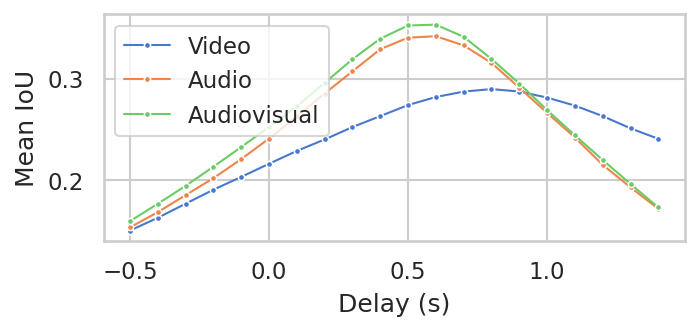

In [62]:
sns.set_style("whitegrid")
sns.set_palette("muted")
matplotlib.rcParams.update({'font.size': 6})
fig, ax = plt.subplots(1, 1, figsize=(5, 2), dpi=150)
x = corrections
sns.lineplot(ax=ax, x=x, y=ious['video'],label='Video', marker='o', linewidth=1, markersize=3)
sns.lineplot(ax=ax, x=x, y=ious['audio'], label= 'Audio', marker='o', linewidth=1, markersize=3)
sns.lineplot(ax=ax, x=x, y=ious['av'], label='Audiovisual', marker='o', linewidth=1, markersize=3)
ax.legend(loc='upper left')
ax.set_xlabel('Delay (s)')
ax.set_ylabel('Mean IoU')

In [63]:
fig.savefig('./figures/ious.png', dpi=300, bbox_inches='tight')

### IoUs accross conditions

These are the average IoUs for the three different conditions, only in cases where:
- the example contained laughter (per GT)
- the example was annotated as laughter

In [64]:
pd.DataFrame([{k: np.mean(v) for k, v in ious.items()}])

,video,audio,av
0,0.2408,0.2533,0.261


In [65]:

ious_video = []

# Bout-level analysis

In [66]:
def get_num_bouts(arr):
    arr = arr[arr[:,0] != 0]
    diff = np.diff(arr[:, 1])
    num_bouts = np.sum(diff == 1)
    return num_bouts

In [67]:
num_bouts = []
for arr in cont_annot:
    num_bouts.append(get_num_bouts(arr.to_numpy()))
results['num_bouts'] = num_bouts

## How often do annotators annotate >1 bout?

Here I counted the bouts and gather some statistics on the number of bouts per annotator

- Each column is one annotator.

Clearly some people tend to consistently annotate more bouts than others, but everybody annotated 2 bouts or more at least once.

In [68]:
df = []
for hit_id in results['hit_id'].unique():
    subject_data = results[results['hit_id'] == hit_id]
    df.append({
        '0 bouts': len(subject_data[subject_data['num_bouts'] == 0]),
        '1 bout': len(subject_data[subject_data['num_bouts'] == 1]),
        '2 bouts': len(subject_data[subject_data['num_bouts'] == 2]),
        '>2 bouts': len(subject_data[subject_data['num_bouts'] > 2]),
        'total': len(subject_data)
    })
pd.DataFrame(df).transpose()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0 bouts,28,36,36,90,23,25,27,27,32,31,...,24,27,32,26,31,90,23,29,36,33
1 bout,48,44,43,0,34,44,48,47,53,51,...,44,50,42,42,44,0,53,56,42,49
2 bouts,11,8,8,0,12,14,12,12,5,7,...,16,13,13,16,14,0,9,5,10,5
>2 bouts,3,2,3,0,4,7,3,4,0,1,...,6,0,3,6,1,0,5,0,2,3
total,90,90,90,90,73,90,90,90,90,90,...,90,90,90,90,90,90,90,90,90,90
